# How to use the MCMC output file

In [1]:
%matplotlib inline
import numpy as np
import TOFPlanet
import ppbs
import observables
import ahelpers as ah
import samplooker as spl

When the MCMC driver finished its job, it saves the resulting chain-ensemble in the file `final.npz` in the run directory. The periodic checkpoints in `dump0.npz` and `dump1.npz` have the same format. Let's look at an example.

In [2]:
fname = 'final.npz'
C, L = ah.load_chain(fname)
print(f'{C.shape=}')
print(f'{L.shape=}')

C.shape=(160, 4400, 8)
L.shape=(160, 4400)


The array `C`, for "chains," has all the numbers you need to define the planet models. Its shape is `w`, number of "walkers", by `n`, number of steps, by `d`, number of dimensions. For example this file is the output of a `drive-ppbs.py` run. The ppbs parameerization has 8 dimensions (plus potentially rotation period, which in this run was kept constant). This was a run of 160 walkers, taking 4400 steps each. A vector of parameters for one planet will be something like, say, `C[2,24,:]`, meaning the 25th step of the third walker. The walkers are a feature of the so-called "ensemble" MCMC algorithm. We need the walker-by-walker data only to diagnose sampling problems and figure out auto-correlation distance. Afterwards we will forget about walkers and end up with an array of something-by-8, of (hopefully) independent samples.

The array `L`, for "likelihood," has the likelihood values for each step of each walker. This is sometimes needed for debugging and diagnosing issues, or for detecting outliers.

## Trace plots

The first thing we look at are trace plots. These are plots of one parameter value a versus step number, showing the progression of a walker through parameter space. A useful view is to plot, for each dimension, the traces of all walkers on a single graph. Since there are typically many walkers and a great many steps, it's best to avoid lines or even traditional markers and simply put a colored pixel at each data point. (This is what the `,` linestyle means in matplotlib.)

Trace plots are implemented in the `ahelpers` module. Here is a trace plot of the first dimension of the 8-dimensional ppbs parameter space.

Help on function plot_traces in module ahelpers:

plot_traces(fname, ws='all', dims='all', burn=0, **kwargs)
    Visually inspect chain traces.

C.shape = (160, 4400, 8)


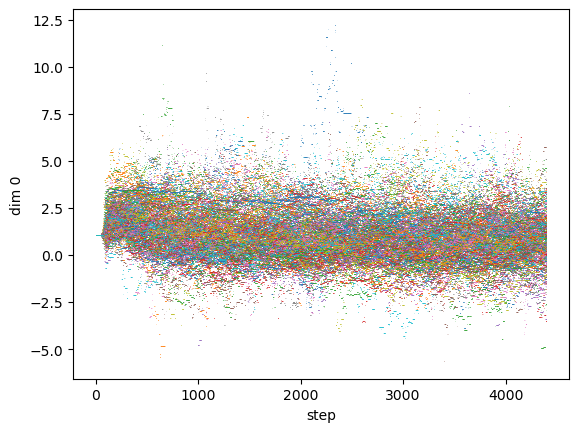

In [3]:
help(ah.plot_traces)
ah.plot_traces(fname, dims=0)

The purpose of the trace plot is to verify that the chain is well-mixed and has sufficient coverage of parameter space. A jumble of colors that shows no clear pattern is the best outcome. If you look closely (zoom in) you can see how all the walkers started from a single seed, with a tiny amount of random noise added so they are not identical, and then quickly spread out and started to explore different values. The ensemble sampler uses the set of walkers to generate a random direction for each walker to step towards, at every step, but the end result is supposed to be random and independent set of values in each walker individually. Be warned, things are not always so easy! It is important to look at the traces for all dimensions.

If you zoom in more and try to follow one walker, you will see that it doesn't change value on every step. Typically, the chain of values taken by a walker sticks with some value for several steps, then changes to a different value and sticks with it for a few steps. In fact every step begins with by suggesting a new "candidate" value. Actually, a vector of candidate values in all dimensions. The likelihood functions is evaluated at the candidate position and, depending on the ratio of likelihoods of the candidate position and the current position, as well as random chance, the candidate may or may not be selected. If it isn't, the chain will instead grow by adding a copy of the current position. The overall _acceptance ratio_ is a useful measure of the sampling efficiency. Something in the range of a few to a few ten percents is expected for well behaved samples. Be warned, things are not always so easy!

In [4]:
ah.acceptance_ratio(C).mean()

0.1922599431818182

## Histograms

So a chain includes several duplicates of one values, then some duplicates of a different value, and then another value. The more likely values (yielding model planets with closer matching observables) are less likely to be replaced by a candidate, and the chain will therefore contain more copies of them. This is how the sample represents, hopefully, the underlying (and unknown) probability distribution.

We can see the approximate implied probability density of each dimension with a histogram. For example, here is the histogram of the last dimension of ppbs.

C.shape = (704000, 8)


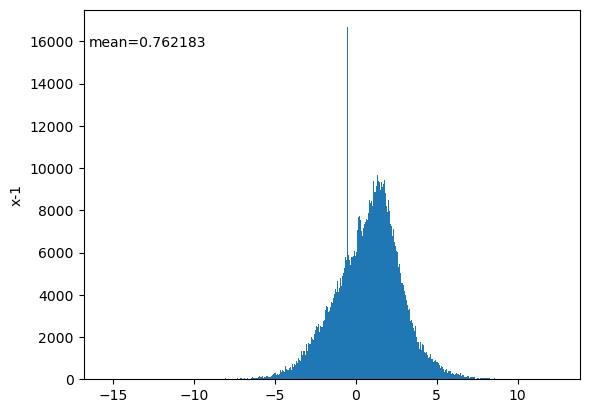

In [5]:
ah.plot_histograms(fname, dims=-1)

See that weird "spike". It's not hard to understand where it comes from. It's the seed! All walkers started from that seed, and whether it represented a high-likelihood or low-likelihood point, it took a while to get away from it. For this reason it is important to throw out the first $k$ steps of each walker. This is called the burn-in phase. By looking at the trace plot, we may reasonably comclude that after, say, $k=1000$ steps, the influence of the seed was forgotten. We'll take `burn=1000` for this chain. (Remember, it is important to look at the traces of all dimensions! If one dimension takes longer to burn-in, we must discard those steps from _all_ dimensions.)

C.shape = (544000, 8)


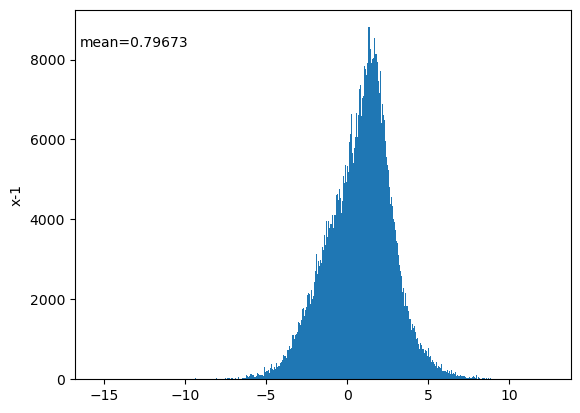

In [6]:
ah.plot_histograms(fname, dims=-1, burn=1000)

Okay, this looks like a nice, reasonable, vaguely gaussian distribution. With a center around zero and width about five. But what are these values to us? The last dimension of ppbs represented the "core" radius. To see the distribution of values of the physically meaningful parameters, we can pass the name of a transformation in the `trans` argument.

C.shape = (544000, 8)


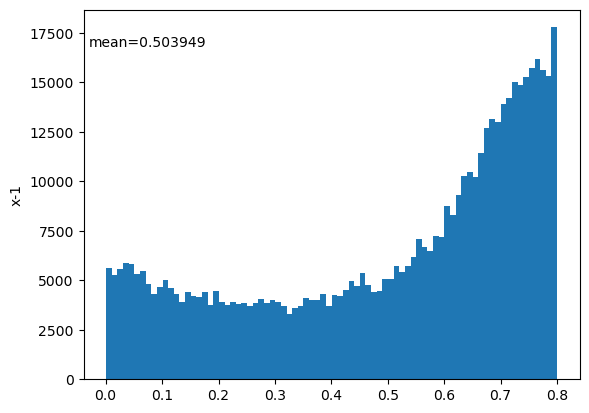

In [7]:
ah.plot_histograms(fname, dims=-1, burn=1000, trans=ppbs._transform)

## Correlations

This is the annoying part. We have a chain of $w$ walkers with $n-k$ steps each (after removing $k$ steps during burn in). This represents a large number of parameter vectors, but they are not independent. What we want is a managable number, say 1000, of independent vectors to serve as our sample. We can take every $s$ step, from each walker, skipping eveything in between. The larger we choose $s$ the more likely it is we will get independent samples. But if we pick $s$ too large we will have a very small sample. The idea is to pick it larger than the longest _autocorrelation length_ of all the dimensions. Autocorrelation plots are available in matplotlib. Here is the autocorrelation plot of the first dimension of the first walker.

C.shape = (3400, 8)


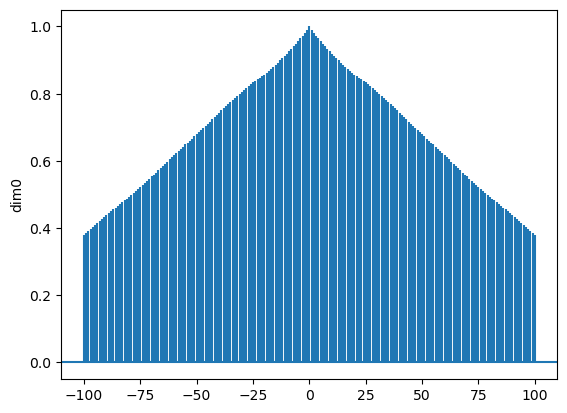

In [8]:
ah.plot_correlations(fname, dims=[0], burn=1000)

The pattern shows that there is correlation between neighboring links. Let's try skipping 10 steps.

C.shape = (340, 8)


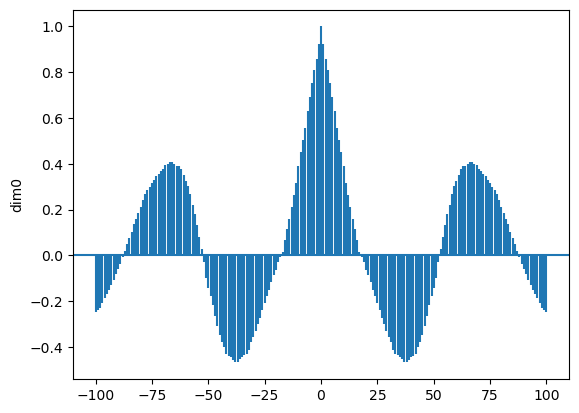

In [9]:
ah.plot_correlations(fname, dims=[0], burn=1000, skip=10)

Still looks cprrelated. Let's try 20.

C.shape = (170, 8)


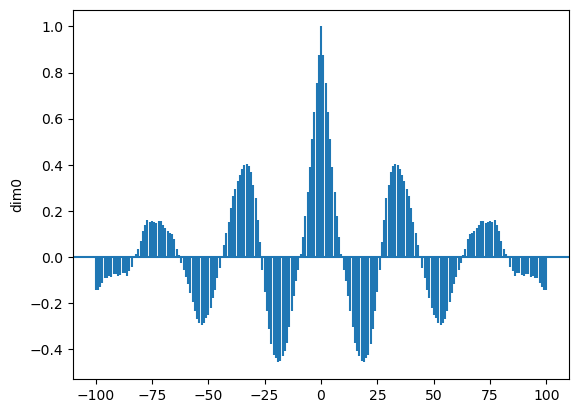

In [10]:
ah.plot_correlations(fname, dims=[0], burn=1000, skip=20)

Better, but not perfect yet. I'd say skipping at least 100 or more would be wise. Let's try 200. We'll have to plot shorter lengths though.

C.shape = (17, 8)


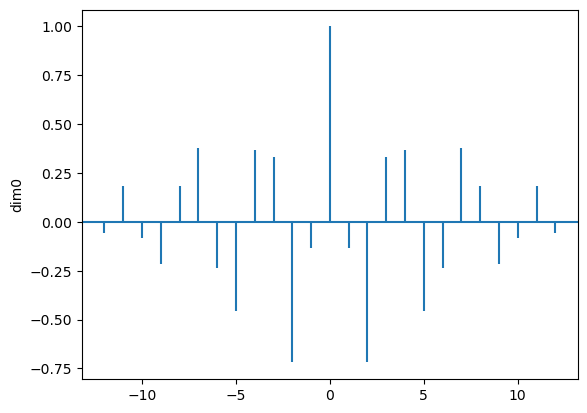

In [11]:
ah.plot_correlations(fname, dims=[0], burn=1000, skip=200, ml=12)

Okay that looks fine. However. Ideally, we should do this exercise for every dimension and every walker. In practice the output of more difficult sampling runs, including matching Js, will never look like this. I usually don't do this for every sample. This is a good diagnostic exercise and worth doing once in a while, but for regular samples I usually just take a longest skip that would leave me with 1000 models overall, from all walkers. If I have reason to suspect this skip retains too much correlation, I run the sampler to get longer chains. If that doesn't help, I give up.

## Samplifying the chain

So. We used the trace plots to pick a `burn` value. And maybe used the autocorrelation plots to guess a minimum `skip` value. Now we can finallly "samplify" our chain; convert the array of many walkers and many steps into an array of `nsample`-by-`ndimension` of parameters we will call our sample, and will make planets from. If we skip, say, 400 steps in each walker, we'll get about 10 positions from each, or about 1000 overall. It's okay to not be exact at this point.

In [12]:
ah.samplify_chain(fname, burn=1000, skip=400)

Z.shape = (1440, 8)
saving to samplified\final.npz
saving to samplified\final.txt


The file `samlpified/final.txt` now contains our sample. At this point I would rename it something else and move it to a different directory where we hold samples of different models. For example,

In [13]:
!ls uranus/ppbs_one/

benno_orig_seed.txt
onepoly_seed.txt
PF_tof4_J0_obs1_monoseed.txt


I try to name the files with information about the run that produced them. The PF stands for "period fixed" meaning we used the nominal rotation period of the planet instead of letting it be another free parameter. The J0 means the likelihood function was trying to match mass, radius, 1-bar, density, and the standard constraints that all models must match, but not the gravity. (This is why the sampling was so fast; we would need much more than 4400 steps if we were trying to match gravity.)

## What next?

Next we want to take the parameter vectors in the sample file and make `TOFPlanet` objects. You may wonder why we didn't simply keep the planet models calculated during the sampling run. True, the sampling driver works by using the parameter vectors to create `TOFPlanet` objects and calls `relax_to_barotrope()` on them, for the purpose of evaluating the likelihood. This is the time consuming part of the run, and it would make sense to save that information. Unfortunately this is also a memory consuming part of the run. The density and pressure profiles form each `TOFPlanet` take a few MB of memory, and the MCMC run might calculate millions of them. Saving them in memory is out of the question and reading/writing them from disk is also not fun. And we don't need millions of model planets to make inferences from. So we just save the parameter values and recreate the model planets as needed. For example, to create a file with 1000 `TOFPlanet`s ready for analysis, change `-n=10` to `-n=1000` below. (And wait 10-15 minutes.)

In [14]:
%run ppbs_planets_from_sample.py samplified/final.txt Uranus -n=10

Found 1440 records in samplified/final.txt.
Cooking planets...
cooking planet 1 of 10...done.
cooking planet 2 of 10...done.
cooking planet 3 of 10...done.
cooking planet 4 of 10...done.
cooking planet 5 of 10...done.
cooking planet 6 of 10...done.
cooking planet 7 of 10...done.
cooking planet 8 of 10...done.
cooking planet 9 of 10...done.
cooking planet 10 of 10...done.
Cooking planets...done (0.0071 hours).
pickled 10 planets in samplified/final_planets.pickle.


<Figure size 640x480 with 0 Axes>

Stay tuned for the next notebook, which will cover how to look at (plot) the planet samples, in python and in matlab.

## What could go wrong?

Plenty. In practical runs it is common to find some walkers get "stuck" in their own regions. Sometimes it is evident that the end result is nothing more than some random noise on top of the seed. There are ways to deal with those situations. But let's leave it to another time/notebook.